# Laboratorio de data mining
Vamos a usar el dataset de http://archive.ics.uci.edu/ml/datasets/wiki4HE, que son dos encuentas de uso de Wikipedia en distintas universidades

In [1]:
# Para visuzalización en notebook
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['font.size'] = 22
from IPython.display import Audio, Markdown, Image
import pylab
#import seaborn as sns

# Números y Datos
import numpy as np
import pandas as pd
import random

# Archivos
import urllib.request
import glob

def dmd(x):
    display(Markdown(x))

# Clustering (scipy)
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster

# Clustering (sklearn)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors

from sklearn_extra.cluster import KMedoids

from sklearn.manifold import TSNE

In [2]:
df = pd.read_csv('data/wiki4HE.csv',sep=';')
df.head()

,AGE,GENDER,DOMAIN,PhD,YEARSEXP,UNIVERSITY,UOC_POSITION,OTHER_POSITION,OTHERSTATUS,USERWIKI,...,BI2,Inc1,Inc2,Inc3,Inc4,Exp1,Exp2,Exp3,Exp4,Exp5
0,40,0,2,1,14,1,2,?,?,0,...,3,5,5,5,5,4,4,4,1,2
1,42,0,5,1,18,1,2,?,?,0,...,2,4,4,3,4,2,2,4,2,4
2,37,0,4,1,13,1,3,?,?,0,...,1,5,3,5,5,2,2,2,1,3
3,40,0,4,0,13,1,3,?,?,0,...,3,3,4,4,3,4,4,3,3,4
4,51,0,6,0,8,1,3,?,?,1,...,5,5,5,4,4,5,5,5,4,4


In [3]:
df.shape

(913, 53)

In [4]:
df.columns

Index(['AGE', 'GENDER', 'DOMAIN', 'PhD', 'YEARSEXP', 'UNIVERSITY',
       'UOC_POSITION', 'OTHER_POSITION', 'OTHERSTATUS', 'USERWIKI', 'PU1',
       'PU2', 'PU3', 'PEU1', 'PEU2', 'PEU3', 'ENJ1', 'ENJ2', 'Qu1', 'Qu2',
       'Qu3', 'Qu4', 'Qu5', 'Vis1', 'Vis2', 'Vis3', 'Im1', 'Im2', 'Im3', 'SA1',
       'SA2', 'SA3', 'Use1', 'Use2', 'Use3', 'Use4', 'Use5', 'Pf1', 'Pf2',
       'Pf3', 'JR1', 'JR2', 'BI1', 'BI2', 'Inc1', 'Inc2', 'Inc3', 'Inc4',
       'Exp1', 'Exp2', 'Exp3', 'Exp4', 'Exp5'],
      dtype='object')

In [5]:
df.describe()

,AGE,GENDER,PhD,UNIVERSITY
count,913.000000,913.000000,913.000000,913.000000
mean,42.246440,0.424973,0.464403,1.123768
std,8.058418,0.494610,0.499005,0.329497
min,23.000000,0.000000,0.000000,1.000000
25%,36.000000,0.000000,0.000000,1.000000
50%,42.000000,0.000000,0.000000,1.000000
75%,47.000000,1.000000,1.000000,1.000000
max,69.000000,1.000000,1.000000,2.000000


# Limpieza y preparación de los datos
## Datos faltantes
Primero revisamos como están codificados los datos faltantes, y encontramos que se uso el signo de pregunta (podrían estar codificados de distintas formas).

In [6]:
df.apply(lambda x: np.sum(x=='?'))

AGE                 0
GENDER              0
DOMAIN              2
PhD                 0
YEARSEXP           23
UNIVERSITY          0
UOC_POSITION      113
OTHER_POSITION    261
OTHERSTATUS       540
USERWIKI            4
PU1                 7
PU2                11
PU3                 5
PEU1                4
PEU2               14
PEU3               97
ENJ1                7
ENJ2               17
Qu1                 7
Qu2                10
Qu3                15
Qu4                22
Qu5                29
Vis1               72
Vis2              117
Vis3                8
Im1                22
Im2                20
Im3                57
SA1                11
SA2                12
SA3                11
Use1               14
Use2               17
Use3                9
Use4               23
Use5               15
Pf1                11
Pf2                 6
Pf3                14
JR1                27
JR2                53
BI1                32
BI2                43
Inc1               35
Inc2      

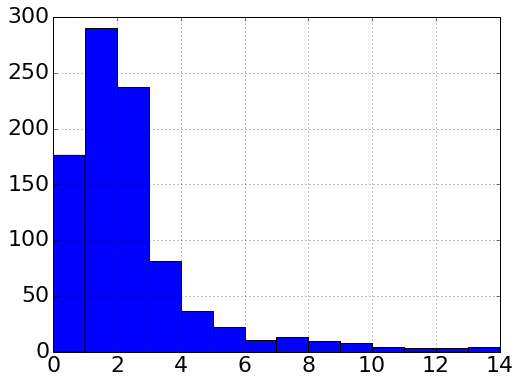

In [7]:
df.apply(lambda x: np.sum(x=='?'),axis=1).hist(bins=range(0,15))

In [8]:
sum(df.apply(lambda x: np.sum(x=='?'),axis=1)==0)

176

Hay pocas variables que concentran muchos valores faltantes. Para simplificar el análisis no vamos a aplicar técnicas de imputación de datos faltantes, pero haremos algunos cambios en el dataset.

La variable OTHER_POSITION sólo tiene sentido para los docentes que tienen otra posición además de la que tienen en UOC. 
Las preguntas Vis2 y Peu3 solo deberían ser respondidos por quienes editan artículos en Wikipedia, o conocen a alguien que lo haga. 
Podemos eliminar estas variables.

In [9]:
df = df.drop(columns=['OTHER_POSITION','Vis2','PEU3'])
sum(df.apply(lambda x: np.sum(x=='?'),axis=1)==0)

188

En una situación de trabajo real, habría que continuar el análisis de los datos faltantes, y considerar aplicar alguna ténica de imputación de datos faltantes. Nosotros nos vamos a quedar con los registros completos. 
Vamos a separar los datos profesionales y demográficos de los encuestados.

In [10]:
df = df[df.apply(lambda x: np.sum(x=='?'),axis=1)==0]
df.shape

(188, 50)

In [11]:
meta = df[['AGE', 'GENDER', 'DOMAIN', 'PhD', 'YEARSEXP', 'UNIVERSITY',
       'UOC_POSITION', 'OTHERSTATUS', 'USERWIKI']]
encu = df.drop(columns=['AGE', 'GENDER', 'DOMAIN', 'PhD', 'YEARSEXP', 'UNIVERSITY',
       'UOC_POSITION', 'OTHERSTATUS', 'USERWIKI'])

# Metadata
Arrancamos con los datos de los encuestados

In [12]:
meta.shape

(188, 9)

## Limpieza y preparación de los datos
Vamos a corregir las categorias (en el caso que corresponda) y el tipo de datos (Numerico, Booleano o logico, y Categorico)

In [13]:
meta.apply(lambda x: type(x.values[1]),axis=0)

AGE             <class 'int'>
GENDER          <class 'int'>
DOMAIN          <class 'str'>
PhD             <class 'int'>
YEARSEXP        <class 'str'>
UNIVERSITY      <class 'int'>
UOC_POSITION    <class 'str'>
OTHERSTATUS     <class 'str'>
USERWIKI        <class 'str'>
dtype: object

Las edades son números enteros... ok

Las siguientes variables deberían ser de tipo factor: GENDER, DOMAIN, UOC_POSITION, UNIVERSITY y OTHERSTATUS. Estas conversiones son importantes para evitar más adelante calcular, por ejemplo, distancias Euclídeas entre sexos o entre dominios de trabajo. En algunos casos, y para aumentar la claridad vamos a especificar los niveles de estas variables.

In [14]:
conditions = [(meta['GENDER'] == 0), (meta['GENDER'] == 1)]
choices = ['M', 'F']
meta['GENDER'] = np.select(conditions, choices)
meta['GENDER'] = meta['GENDER'].astype('category')
meta['GENDER'].unique()

/home/juank/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/juank/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[M, F]
Categories (2, object): [M, F]

Al resto de las variables tengo que acomodarles las categorias. Ya no tiene datos faltantes, si no se lo agrego como una categoria más.

In [15]:
#meta['DOMAIN'].astype('float').unique()
conditions = [(meta['DOMAIN'] == '1'), 
              (meta['DOMAIN'] == '2'),              
              (meta['DOMAIN'] == '3'),              
              (meta['DOMAIN'] == '4'),              
              (meta['DOMAIN'] == '5'),              
              (meta['DOMAIN'] == '6')]
choices = ['Arts_Humanities','Sciences','Health_Sciences','Engineering_Architecture','Law','Political_Sciences']
meta['DOMAIN'] = np.select(conditions, choices)
meta['DOMAIN'] = meta['DOMAIN'].astype('category')
meta['DOMAIN'].unique()

/home/juank/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juank/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[Political_Sciences, Law, Arts_Humanities, Sciences, Engineering_Architecture, Health_Sciences]
Categories (6, object): [Political_Sciences, Law, Arts_Humanities, Sciences, Engineering_Architecture, Health_Sciences]

In [16]:
conditions = [(meta['UOC_POSITION'] == '1'), 
              (meta['UOC_POSITION'] == '2'),              
              (meta['UOC_POSITION'] == '3'),              
              (meta['UOC_POSITION'] == '4'),              
              (meta['UOC_POSITION'] == '5'),              
              (meta['UOC_POSITION'] == '6')]
choices = ['Professor','Associate','Assistant','Lecturer','Instructor','Adjunct']
meta['UOC_POSITION'] = np.select(conditions, choices)
meta['UOC_POSITION'] = meta['UOC_POSITION'].astype('category')
meta['UOC_POSITION'].unique()

/home/juank/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juank/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[Adjunct]
Categories (1, object): [Adjunct]

In [17]:
# OTHERSTATUS: Queda codificado como númenro porque los nombres de categorías no coinciden con el número de categorías
meta['OTHERSTATUS'] = meta['OTHERSTATUS'].astype('category')
meta['OTHERSTATUS'].unique()

/home/juank/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


[7, 3, 2, 6, 4, 1, 5]
Categories (7, object): [7, 3, 2, 6, 4, 1, 5]

In [18]:
conditions = [(meta['UNIVERSITY'] == 1), (meta['UNIVERSITY'] == 2)]
choices = ['UOC', 'UPF']
meta['UNIVERSITY'] = np.select(conditions, choices)
meta['UNIVERSITY'] = meta['UNIVERSITY'].astype('category')
meta['UNIVERSITY'].unique()

/home/juank/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/juank/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[UOC]
Categories (1, object): [UOC]

Hay tres variables que deberían estar codificadas como de tipo lógico, PhD, USERWIKI y OTHER_POSITION. La variable OTHER_POSITION tiene una particularidad, el valor 1 indica que la persona es docente en UOC y docente part-time en otra universidad, y el valor 2 que no tiene otra posición part-time. Esta variable tiene datos faltantes, por lo que no se puede usar la función ifelse de R base como hicimos con GENDER o PhD. En este caso usamos la versión más estricta if_else() del paquete dplyr (revisar la documentación)

In [19]:
# PhD no tiene datos faltantes
meta['PhD']=meta['PhD'].astype('bool')
meta['PhD'].unique()

/home/juank/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


array([False,  True], dtype=bool)

In [20]:
# La conversion de tipo saca los nans.
# meta['USERWIKI']=pd.to_numeric(meta['USERWIKI'].replace('?',np.nan),errors='coerce').astype('bool')
meta['USERWIKI']=meta['USERWIKI'].astype('bool')
meta['USERWIKI'].unique()

/home/juank/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


array([ True], dtype=bool)

Remuevo las variables que no van a servir para discriminar grupos porque tienen un único valor sobre el conjunto de registros que están completos.

In [21]:
meta = meta.drop(columns=['UNIVERSITY','UOC_POSITION','USERWIKI'])

In [22]:
meta.apply(lambda x: type(x.values[1]),axis=0)

AGE            <class 'numpy.int64'>
GENDER                 <class 'str'>
DOMAIN                 <class 'str'>
PhD            <class 'numpy.bool_'>
YEARSEXP               <class 'str'>
OTHERSTATUS            <class 'str'>
dtype: object

## Análisis
Vamos a construir una matriz de distancias de Gower para los datos personales, y realizamos un cluster jerárquico para tener una primera impresión sobre cómo se agrupan los datos.

In [23]:
from funciones import gower_distances

In [24]:
d=gower_distances(meta)
d

[False  True  True  True  True  True]


array([[ 0.        ,  0.35185185,  0.66666669, ...,  0.75925928,
         0.69907409,  0.8611111 ],
       [ 0.35185185,  0.        ,  0.68518519, ...,  0.77777779,
         0.7175926 ,  0.87962961],
       [ 0.66666669,  0.68518519,  0.        , ...,  0.5925926 ,
         0.5324074 ,  0.52777779],
       ..., 
       [ 0.75925928,  0.77777779,  0.5925926 , ...,  0.        ,
         0.22685185,  0.39814815],
       [ 0.69907409,  0.7175926 ,  0.5324074 , ...,  0.22685185,
         0.        ,  0.33796296],
       [ 0.8611111 ,  0.87962961,  0.52777779, ...,  0.39814815,
         0.33796296,  0.        ]], dtype=float32)

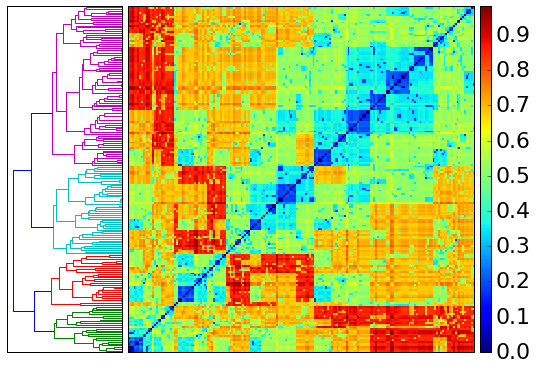

In [25]:
# Abrir figura nueva
fig = pylab.figure()

# Calcular dendrograma y graficar.
axdendro = fig.add_axes([0.09,0.1,0.2,0.8])
Y = linkage(d, method='average')
Z = dendrogram(Y, orientation='right')
axdendro.set_xticks([])
axdendro.set_yticks([])
axdendro.invert_xaxis()

# Graficar la matriz de distancias.
axmatrix = fig.add_axes([0.3,0.1,0.6,0.8])
index = Z['leaves']
d = d[index,:]
d = d[:,index]
im = axmatrix.matshow(d, aspect='auto', origin='lower')
axmatrix.set_xticks([])
axmatrix.set_yticks([])

# Graficar la barra de color
axcolor = fig.add_axes([0.91,0.1,0.02,0.8])
pylab.colorbar(im, cax=axcolor)

#### ¿Qué se puede decir de la presencia de grupos en el dataset?

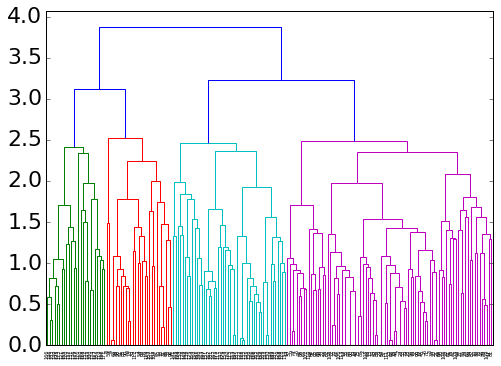

In [26]:
Z = dendrogram(Y)

#### PAM
Para agrupar los datos datos vamos a usar el método PAM, y como desconocemos el mejor valor de K a utilizar, vamos a probar varios y después usar los gráficos de SSE vs. k y Silhouette vs. k.
En el loop de más abajo se recorren los valores de k desde 2 hasta el máximo número de k (cantidad de clusters) que se van a probar. En cada iteración se calcula un nuevo PAM y con sus medoides se calcula el SSE y Silhouette.

In [27]:
from funciones import cluster

In [28]:
out = cluster(d,4)
etiquetas = out[0]
medoides = out[1]

In [29]:
silhouette_score(d,etiquetas,metric='precomputed')

0.084232405

In [30]:
silhouette_samples(d,etiquetas,metric='precomputed')

array([ 0.23193444,  0.24199003,  0.23412634,  0.24718538,  0.21284528,
        0.23433298,  0.15186882,  0.18813632, -0.00824538,  0.10403326,
       -0.09180831, -0.07698753, -0.00601124,  0.14433406,  0.14173985,
        0.11607423,  0.10585856, -0.06560063, -0.06016627, -0.05631695,
        0.13983987,  0.16720866,  0.15060851,  0.16531231,  0.16075313,
        0.1269404 , -0.03419868,  0.28994456,  0.28931791,  0.26020008,
        0.24682833,  0.20979728,  0.26769713,  0.26895821,  0.29779515,
        0.29691017, -0.11557394,  0.09640781, -0.10108448,  0.13663308,
       -0.05748872, -0.12731549,  0.06802093, -0.03221134,  0.09920731,
        0.15175024, -0.13433859, -0.10347885, -0.08792226,  0.07158384,
        0.24241768,  0.14662412,  0.16348955, -0.06415088,  0.0171821 ,
        0.28329942,  0.10170805,  0.08293407, -0.08758066, -0.10002942,
        0.02278862,  0.13355824,  0.03090608, -0.02317643, -0.01472009,
       -0.01287701,  0.15185028,  0.10161701,  0.08981796,  0.11

In [31]:
def calculo_sse(d,etiquetas,medoides):
    sse = 0.
    for i in range(0,len(medoides)):
        sse = sse + sum(np.power(d[etiquetas==medoides[i],medoides[i]],2))
    return sse

In [32]:
kmax = 14
itmax = 1000
sse = []
sil = []
ketiquetas = []
kmedoides = []
for k in range(2,kmax+1):
    tmp1 = 0
    for it in range(0,itmax):
        out = cluster(d,k)
        tmp2 = silhouette_score(d,out[0],metric='precomputed')
        if tmp2>tmp1:
            etiquetas = out[0]
            medoides = out[1]
    
    sil.append(silhouette_score(d,etiquetas,metric='precomputed'))
    sse.append(calculo_sse(d,etiquetas,medoides))
    kmedoides.append(medoides)
    ketiquetas.append(etiquetas)

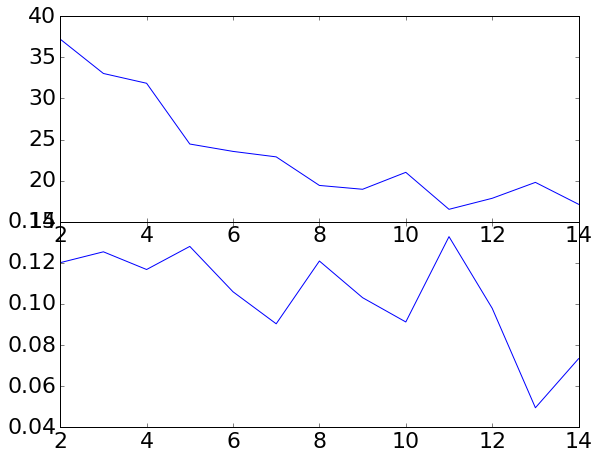

In [33]:
x = np.arange(2, kmax+1)

# Abrir figura nueva
fig = pylab.figure()

# Silhoutte.
axsil = fig.add_axes([0.05,0.05,0.9,0.475])
plt.plot(x,sil)

# SSE
axsse = fig.add_axes([0.05,0.525,0.9,0.475])
plt.plot(x,sse)

*. ¿Cómo se interpretan estos gráficos?
*. ¿Por qué el valor de Silhouette sube, baja a partir de k > 4 y después vuelve a subir gradualmente? Ayuda: mirar el cluster jerárquico que hicimos antes.

Probamos primero con k=14.

In [34]:
# Estimar el coeficiente de Silhouette para cada cluster
n_clusters=14
cluster_ids = kmedoides[n_clusters-2]
cluster_labels = ketiquetas[n_clusters-2]
sample_silhouette_values = silhouette_samples(d,cluster_labels,metric='precomputed')
silhouette_avg = silhouette_score(d,cluster_labels,metric='precomputed')

In [35]:
from funciones import plot_silhouette

In [36]:
plot_silhouette(n_clusters,cluster_ids,cluster_labels,sample_silhouette_values,silhouette_avg)

NameError: name 'plt' is not defined

Veamos los valores que toman los prototipos

In [ ]:
meta.iloc[cluster_ids]

También se puede evaluar si los clusters están o no aislados. Es decir, si un elemento de otro cluster entra en la elipse formada por un dado cluster.

Y un gráfico para ver la relación entre grupos e individuos (cluster plot).

In [ ]:
x = TSNE(n_components=2, init='random').fit_transform(d)
for i in range(n_clusters):
    colo = cm.nipy_spectral(float(i) / n_clusters)
    plt.scatter(x[cluster_labels == cluster_ids[i],0],x[cluster_labels == cluster_ids[i],1],color=colo)

Para este ejercicio nos quedamos con k=4, que no es necesariamente el mejor valor.

### Clustering por densidad
Antes de realizar el paso de clustering tenemos que buscar el valor adecuado de eps. Para minPts usaremos el default de cinco. Como ya tenemos una matriz de distancia calculada, simplemente para cada registro recuperamos la quinta distancia a los otros.

### Clustering difuso
Vamos a realizar un clustering difuso, con la misma matriz de distancia de Gower que venimos trabajando y cuatro grupos.

#### ¿Qué indica el coeficente de Dunnet?
#### ¿Cuátos registros (docentes) se pueden asignar claramente a un grupo?
Combinamos lo que acabamos de hacer con un ordenamiento hecho por escalamiento métrico no dimensional (NMDS). Primero con las asignaciones originales y la otra marcando en negro los “encuestados difusos”.

## Análisis de las respuestas a las encuestas
Primero realicemos un cluster con el método PAM usando las distancias Euclideas entre respuestas. Veamos, además, algunas características adicionales de la salida de la función pam().

### Extracción de datos
Las dos líneas de código que siguen son para ver y almacenar en un objeto de R los valores que toman los medoides de cada objeto clusterizado.

A continuación buscaremos el mejor valor de K para agrupar. El loop en esencia es similar al que usamos antes para los datos personales, con algunas diferencias. Como argumento de la función pam() le estamos pasando una matriz de datos, no una matriz de distancia como hicimos antes, y especificamos que la distancia a calcular es euclidea y que mantenga la matriz de distancia resultante en la salida (keep.dis = T).

Como en este caso pam() “ve” los datos, en medoids no solo guarda el ID del prototipo, sino sus datos completos. Por lo tanto, para recuperar la distancia entre un objeto y su medoide necesitamos especificar que necesitamos el ID del medoide, por eso vec.meds tiene una asignación diferente de la que habíamos hecho antes para pers.meds:

vec_meds <- row.names(preguntas_pam[Math Processing Error]clustering] *
Luego, la matriz de distancia es simplemente una propiedad del objeto que devuelve pam():

preguntas_pam$diss *

### Una función de distancia para variables categóricas ordenadas.
Las respuestas están codificadas con cinco valores enteros ordenados. En consecuencia, en lugar de la distancia euclídea, podríamos usar alguna de distancia para variables categóricas ordenadas, como la que vimos en la térocia de medidas de (di)similitud. Para normalizar las distancias entre 0 y 1, vamos a tener en cuenta que el máximo valor de disimilitud es la máxima diferencia entre respuestas, 5-1 = 4. Por ejemplo, para la distancia entre dos encuestados cualquiera:

Vamos a repetir esto para todos los encuestados para crear la matriz de distancias.

Y repetimos la misma actividad de antes, buscamos el k óptimo.

En este caso, el análisis con Silhouette indica más fuertemente usar un k=2, y con SSE, como pasó antes, no se ve un claro ganador. Probemos con k=3.

¿Cómo se agrupan los encuestados según sus respuestas?

Y según sus características demográficas y profesionales ¿Cómo se distribuyen sobre la nube de respuestas?

Como una visualización complementaria podemos ver cómo se distribuyen según sus respuestas en el clustering por características deomgráficas y personales.

Finalmente, podemos hacer una matriz de confusión entre ambos agrupamientos para determinar si hay alguna asociación entre grupos demograficos y perfil de respuestas a la encuesta.

Como mencionamos antes, para analizar este trabajo en un contexto real de investigación harían falta algunos pasos más y profundizar algunos de los realizados. Pero el objetivo principal de este laboratorio fue aprender cómo aplicar y evaluar técnicas de clustering.